# Theory Predictions and their Uncertainties

EOS can produce theory predictions for any of its built-in observables. The examples following in this section illustrate how to find a specific observable from the list of all built-in observables, construct an [eos.Observable](../reference/python.rst#eos.Observable) object and evaluate it, and estimate the theoretical uncertainties associated with it.

## Listing the built-in Observables

The full list of built-in observables for the most-recent EOS release is available online [here](https://eos.github.io/doc/reference/observables). You can also show this list using the [eos.Observables](../reference/python.rst#eos.Observables) class. Searching for a specific observable is possible by filtering for specific strings in the observable name’s *prefix*, *name*, or *suffix* parts. The following example only shows observables that contain a `'D'` in the prefix part and `'BR'` in the name part:

In [1]:
import eos
eos.Observables(prefix='D', name='BR')

## Constructing and Evaluating an Observable

To make theory predictions of any observable, EOS requires its full name, its [eos.Parameters](../reference/python.rst#eos.Parameters) object, its [eos.Kinematics](../reference/python.rst#eos.Kinematics) object, and its [eos.Options](../reference/python.rst#eos.Options) object. As an example, we will use the integrated branching ratio of $B^-\to D\ell^-\bar\nu$, which is represented by the name ``B->Dlnu::BR``. The latter is a well formed [eos.QualifiedName](../reference/python.rst#eos.QualifiedName), which is used throughout EOS to address observables and other objects. Additional information about any given observable can be obtained by displaying the full database entry, which also contains information about the kinematic variables required:

In [2]:
eos.Observables()['B->Dlnu::BR']

Note that in the above we display a single observable by name using the ``[]`` operator.

From the above output we understand that the observable ``B->Dlnu::BR`` expects two kinematic variables, corresponding here to the lower and upper integration boundaries of the dilepton invariant mass ``q2``.

We proceed to create an [eos.Observable](../reference/python.rst#eos.Observable) object for ``B->Dlnu::BR`` with the default set of parameters and options,
and then display it:

In [3]:
parameters = eos.Parameters.Defaults()
kinematics = eos.Kinematics(q2_min=0.02, q2_max=11.60)
obs = eos.Observable.make('B->Dlnu::BR', parameters, kinematics, eos.Options())
display(obs)

The default option ``l=mu`` select $\ell=\mu$ as the lepton flavour. The value of the observable is shown
to be about $2.4\%$,
which is compatible with the current world average for the $\bar{B}^-\to D^0\mu^-\bar\nu$ branching ratio.

By setting the ``l`` option to the value ``tau``, we create a different observable representing the $\bar{B}^-\to D^0\tau^-\bar\nu$ branching ratio:

In [4]:
kinematics = eos.Kinematics(q2_min=3.17, q2_max=11.60)
obs = eos.Observable.make('B->Dlnu::BR', parameters, kinematics, eos.Options(l='tau'))
display(obs)

The new observable yields a value of $0.71\%$.

So far we evaluated the integrated branching ratio. EOS also provides the corresponding differential branching ratio as a function of the squared momentum transfer $q^2$.
The differential branching fraction is accessible through the name ``B->Dlnu::dBR/dq2``.
To illustrate it, we use EOS's plot functions:

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$q^2$\\,[$\\textnormal{GeV}^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

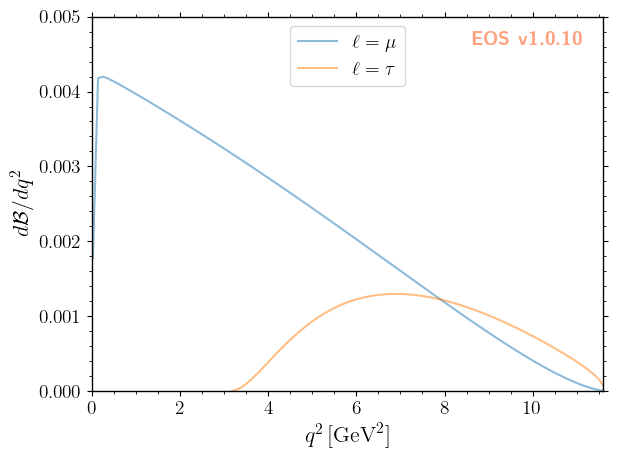

In [5]:
plot_args = {
    'plot': {
        'x': { 'label': r'$q^2$', 'unit': r'$\textnormal{GeV}^2$', 'range': [0.0, 11.60] },
        'y': { 'label': r'$d\mathcal{B}/dq^2$',                    'range': [0.0,  5e-3] },
        'legend': { 'location': 'upper center' }
    },
    'contents': [
        {
            'label': r'$\ell=\mu$',
            'type': 'observable',
            'observable': 'B->Dlnu::dBR/dq2;l=mu',
            'variable': 'q2',
            'range': [0.02, 11.60],
        },
        {
            'label': r'$\ell=\tau$',
            'type': 'observable',
            'observable': 'B->Dlnu::dBR/dq2;l=tau',
            'variable': 'q2',
            'range': [3.17, 11.60],
        }
    ]
}
eos.plot.Plotter(plot_args).plot()

## Estimating Theory Uncertainties

To estimate theoretical uncertainties of the observables, EOS uses Bayesian statistics.
The latter interprets the theory parameters as random variables and assigns *a priori*
probability density functions (prior PDFs) for each parameter.

We carry on using the integrated branching ratios of $\bar{B}^-\to D^0\left\lbrace\mu^-, \tau^-\right\rbrace\bar\nu$ decays as examples.
The largest source of theoretical uncertainty in these decays arises from the hadronic matrix elements, i.e.,
from the form factors $f^{B\to \bar{D}}_+(q^2)$ and $f^{B\to \bar{D}}_0(q^2)$.
Both form factors have been obtained independently using lattice QCD simulations by the HPQCD and Fermilab/MILC (FNAL+MILC) collaborations.
The joint likelihoods for both form factors at different $q^2$ values of each prediction are available in EOS as `Constraint` objects under the names ``B->D::f_++f_0@HPQCD2015A`` and ``B->D::f_++f_0@FNAL+MILC2015B``.

To use these constraints, we must first decide how to parametrize the form factors.
For what follows we will use a simplified series expansion up to order $N = 2$.
The form factors are written as ([BFW:2010A], [BSZ:2015A]): $$f_i(z) = \frac{1}{1 - q^2/m_{R_i}^2} \sum_{k=0}^N \alpha^{f_i}_k z^k \, , \qquad \text{with } z(q^2, t_0) = \frac{\sqrt{t_+ - q^2} - \sqrt{t_+ - t_0}}{\sqrt{t_+ - q^2} + \sqrt{t_+ - t_0}}.$$

For this example, we will use both the HPQCD and the FNAL+MILC results and create a combined likelihood as follows:

In [6]:
analysis_args = {
    'priors': [
        { 'parameter': 'B->D::alpha^f+_0@BSZ2015', 'min':  0.0, 'max':  1.0, 'type': 'uniform' },
        { 'parameter': 'B->D::alpha^f+_1@BSZ2015', 'min': -5.0, 'max': +5.0, 'type': 'uniform' },
        { 'parameter': 'B->D::alpha^f+_2@BSZ2015', 'min': -5.0, 'max': +5.0, 'type': 'uniform' },
        { 'parameter': 'B->D::alpha^f0_1@BSZ2015', 'min': -5.0, 'max': +5.0, 'type': 'uniform' },
        { 'parameter': 'B->D::alpha^f0_2@BSZ2015', 'min': -5.0, 'max': +5.0, 'type': 'uniform' }
    ],
    'likelihood': [
        'B->D::f_++f_0@HPQCD:2015A',
        'B->D::f_++f_0@FNAL+MILC:2015B'
    ]
}
analysis = eos.Analysis(**analysis_args)

Next we create three observables: the semi-muonic branching ratio, the semi-tauonic branching ratio, and the ratio of the former two.
By using [analysis.parameters](../reference/python.rst#eos.Analysis) in the construction of these observables, we ensure that our observables and the [eos.Analysis](../reference/python.rst#eos.Analysis) object share the same parameter set. This means that changes to the analysis' parameters will affect the evaluation of all three observables.

In [7]:
obs_mu  = eos.Observable.make(
    'B->Dlnu::BR',
    analysis.parameters,
    eos.Kinematics(q2_min=0.02, q2_max=11.60),
    eos.Options({'l':'mu', 'form-factors':'BSZ2015'})
)
obs_tau = eos.Observable.make(
    'B->Dlnu::BR',
    analysis.parameters,
    eos.Kinematics(q2_min=3.17, q2_max=11.60),
    eos.Options({'l':'tau','form-factors':'BSZ2015'})
)
obs_R_D = eos.Observable.make(
    'B->Dlnu::R_D',
    analysis.parameters,
    eos.Kinematics(q2_mu_min=0.02, q2_mu_max=11.60, q2_tau_min=3.17, q2_tau_max=11.60),
    eos.Options({'form-factors':'BSZ2015'})
)
observables=(obs_mu, obs_tau, obs_R_D)

In the above, we made sure to provide the option `form-factors=BSZ2015` to ensure that the right form factor plugin is used.

Sampling from the log(posterior) and -- at the same time -- producing posterior-predictive samples of the three observables is achieved as follows:

In [8]:
parameter_samples, _, observable_samples = analysis.sample(N=5000, pre_N=1000, observables=observables)

Pre-runs:   0%|          | 0/3 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Here `N=5000` samples are produced. To illustrate these samples we use EOS' plotting framework:

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$d\\mathcal{B}/dq^2$'>)

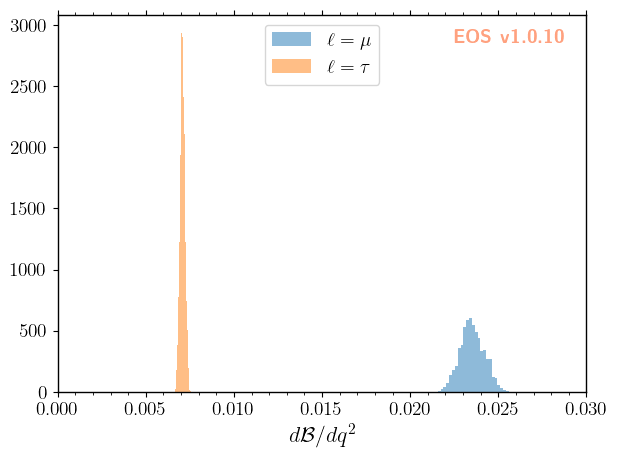

In [9]:
plot_args = {
    'plot': {
        'x': { 'label': r'$d\mathcal{B}/dq^2$',  'range': [0.0,  3e-2] },
        'legend': { 'location': 'upper center' }
    },
    'contents': [
        { 'label': r'$\ell=\mu$', 'type': 'histogram', 'bins': 30, 'data': { 'samples': observable_samples[:, 0] }},
        { 'label': r'$\ell=\tau$','type': 'histogram', 'bins': 30, 'data': { 'samples': observable_samples[:, 1] }},
    ]
}
eos.plot.Plotter(plot_args).plot()

We can convince ourselves of the usefullness of the correlated samples by computing the lepton-flavour universality ratio $R_D$ twice: once using EOS' built-in observable ``B->Dlnu::R_D`` as sampled above,
and once by calculating the ratio manually for each sample:

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$d\\mathcal{B}/dq^2$'>)

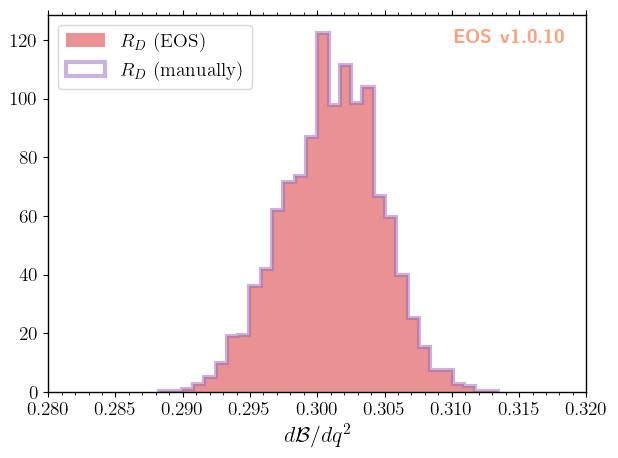

In [10]:
plot_args = {
    'plot': {
        'x': { 'label': r'$d\mathcal{B}/dq^2$',  'range': [0.28,  0.32] },
        'legend': { 'location': 'upper left' }
    },
    'contents': [
        { 'label': r'$R_D$ (EOS)',     'type': 'histogram', 'bins': 30, 'color': 'C3', 'data': { 'samples': observable_samples[:, 2] }},
        { 'label': r'$R_D$ (manually)','type': 'histogram', 'bins': 30, 'color': 'C4', 'data': { 'samples': [o[1] / o[0] for o in observable_samples[:]] },
          'histtype': 'step'},
    ]
}
eos.plot.Plotter(plot_args).plot()

Using the Numpy routines ``numpy.average`` and ``numpy.var`` we can produce numerical estimates
of the mean and the standard deviation:

In [11]:
import numpy as np

print('{obs};{opt}  = {mean:.4f} +/- {std:.4f}'.format(
    obs=obs_mu.name(), opt=obs_mu.options(),
    mean=np.average(observable_samples[:,0]),
    std=np.sqrt(np.var(observable_samples[:, 0]))
))
print('{obs};{opt} = {mean:.4f} +/- {std:.4f}'.format(
    obs=obs_tau.name(), opt=obs_tau.options(),
    mean=np.average(observable_samples[:,1]),
    std=np.sqrt(np.var(observable_samples[:, 1]))
))
print('{obs};{opt}          = {mean:.4f} +/- {std:.4f}'.format(
    obs=obs_R_D.name(), opt=obs_R_D.options(),
    mean=np.average(observable_samples[:,2]),
    std=np.sqrt(np.var(observable_samples[:, 1]))
))

B->Dlnu::BR;I=1/2,U=c,form-factors=BSZ2015,l=mu  = 0.0235 +/- 0.0007
B->Dlnu::BR;I=1/2,U=c,form-factors=BSZ2015,l=tau = 0.0071 +/- 0.0001
B->Dlnu::R_D;form-factors=BSZ2015          = 0.3011 +/- 0.0001


To obtain uncertainty bands for a plot of the differential branching ratios, we can now produce a
sequence of observables at different points in phase space. We then pass these observables on to
[analysis.sample](../reference/python.rst#eos.Analysis.sample), to obtain posterior-predictive samples:

In [12]:
mu_q2values  = np.unique(np.concatenate((np.linspace(0.02,  1.00, 20), np.linspace(1.00, 11.60, 20))))
mu_obs       = [eos.Observable.make(
                   'B->Dlnu::dBR/dq2', analysis.parameters, eos.Kinematics(q2=q2),
                   eos.Options({'form-factors': 'BSZ2015', 'l': 'mu'}))
               for q2 in mu_q2values]
tau_q2values = np.linspace(3.17, 11.60, 40)
tau_obs      = [eos.Observable.make(
                   'B->Dlnu::dBR/dq2', analysis.parameters, eos.Kinematics(q2=q2),
                   eos.Options({'form-factors': 'BSZ2015', 'l': 'tau'}))
               for q2 in tau_q2values]

_, _, mu_samples  = analysis.sample(N=5000, pre_N=1000, observables=mu_obs)
_, _, tau_samples = analysis.sample(N=5000, pre_N=1000, observables=tau_obs)

Pre-runs:   0%|          | 0/3 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/3 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

We can plot the so-obtained posterior-predictive samples with EOS' plotting framework by running:

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$q^2$\\,[$\\textnormal{GeV}^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

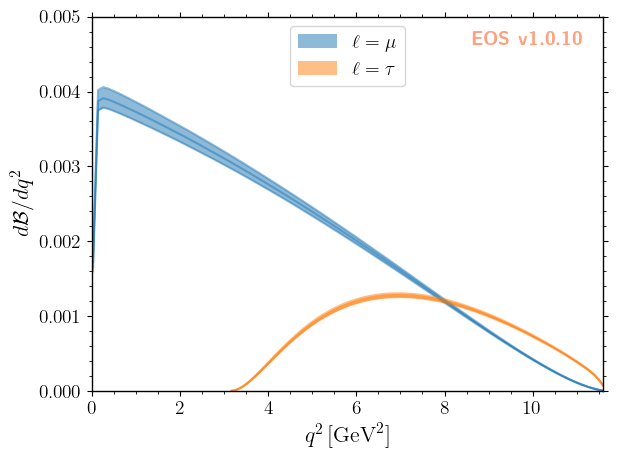

In [13]:
plot_args = {
    'plot': {
        'x': { 'label': r'$q^2$', 'unit': r'$\textnormal{GeV}^2$', 'range': [0.0, 11.60] },
        'y': { 'label': r'$d\mathcal{B}/dq^2$',                    'range': [0.0,  5e-3] },
        'legend': { 'location': 'upper center' }
    },
    'contents': [
        {
          'label': r'$\ell=\mu$', 'type': 'uncertainty', 'range': [0.02, 11.60],
          'data': { 'samples': mu_samples, 'xvalues': mu_q2values }
        },
        {
          'label': r'$\ell=\tau$','type': 'uncertainty', 'range': [3.17, 11.60],
          'data': { 'samples': tau_samples, 'xvalues': tau_q2values }
        },
    ]
}
eos.plot.Plotter(plot_args).plot()